# Modeling Spark Applications

Apache Spark is a very flexible distributed system. As a result of its flexibility, it is difficult to predict the total duration of different applications types. In this work, we use machine learning to find a model that can predict different application types. In the following sections, we analyze two applications: finding the Wikipedia top contributors (inspired by Spark Summit 2014) and HiBench Sort benchmark.

In [1]:
# Initial setup

try:
    plt_inline
except NameError:
    # Avoid small fonts when inlining again
    %matplotlib inline
    plt_inline = True
    
from inc.notebook000 import *

In [2]:
# 3 Apache Spark applications
APPS = ('wikipedia',      # Wikipedia application
        'hbsort',         # HiBench Sort benchmark
        'hbkmeans')       # HiBench K-means clustering benchmark
# 2 sets for every application:
SETS = ('profiling',      # less workers and input data to build the model
        'target')         # we want to predict this target set

# All DataFrames are stored in the "dfs" dictionary
dfs = {app: {s: {} for s in SETS} for app in APPS}

# Wikipedia's Top 10 Contributors
This application outputs the top 10 contributors of the English Wikipedia. The input is the information about the last version of all English Wikipedia articles in JSON format. In the article information, we can find who was the last person to edit it and this counts as one contribution for that person. We measured the first execution of a SQL query that returns the top 10 contributors.

In [3]:
dfb = DFBuilderWiki()

caption = 'Target executions that we want to predict, with different numbers of workers.' \
          ' Total input size is 45 GB.\n'
df = dfb.get_target()
dfs['wikipedia']['target']['original'] = helper.remove_outliers(df, Humanizer(), caption)

caption = 'Profiling executions with less workers and input data. They are used to generate the model.'
df = helper.get_wiki_profiling_df(dfb)
h = Humanizer(size=Humanizer.SIZE_MIB)
dfs['wikipedia']['profiling']['original'] = helper.remove_outliers(df, h, caption)

,workers,input size (GiB),mean (sec),samples,outliers,not outliers
0,4,45,184.20,30,2,28
1,8,45,103.31,30,1,29
2,16,45,64.58,30,2,28
3,32,45,43.88,30,2,28
4,64,45,39.23,30,1,29


Target executions that we want to predict, with different numbers of workers. Total input size is 45 GB.



,workers,input size (MiB),mean (sec),samples,outliers,not outliers
0,1,128,20.44,10,0,10
1,1,256,20.01,10,0,10
2,1,512,23.70,10,0,10
3,1,1024,29.96,10,0,10
4,2,1024,23.53,10,2,8
5,4,1024,20.85,10,0,10


Profiling executions with less workers and input data. They are used to generate the model.


# HB Sort
This is the Sort application from the HiBench suite. It sorts text input data, which is randomly generated. More details in its [GitHub page](https://github.com/intel-hadoop/HiBench) (there's also a paper about it with more details of the workload).

In [4]:
dfb = DFBuilderSort()
# Remove disk access
# TODO use prediction
df = dfb._get_all()
i = df.input
w = df.workers
dfb._all = df[(i != 3284983900) | (w != 1)]

caption = 'Target executions that we want to predict, with different numbers of workers.' \
          ' We used two problem sizes from the HiBench suite.\n'
df = helper.get_sort_target_df(dfb)
dfs['hbsort']['target']['original'] = helper.remove_outliers(df, Humanizer(), caption)

caption = 'Profiling executions with less workers and input data. They are used to generate the model.'
df = dfb.get_profiling()
h = Humanizer(size=Humanizer.SIZE_MIB)
dfs['hbsort']['profiling']['original'] = helper.remove_outliers(df, h, caption)

dfb.free()

,input size (GiB),workers,mean (sec),samples,outliers,not outliers
0,3,2,133.99,10,1,9
1,3,4,87.36,10,1,9
2,3,8,61.92,10,1,9
3,3,16,47.48,10,0,10
4,31,16,328.36,10,1,9
5,31,32,284.54,10,1,9
6,31,64,286.15,10,2,8
7,31,128,174.30,10,0,10


Target executions that we want to predict, with different numbers of workers. We used two problem sizes from the HiBench suite.



,input size (MiB),workers,mean (sec),samples,outliers,not outliers
0,263,1,31.24,10,1,9
1,263,2,26.29,10,1,9
2,526,1,49.05,10,2,8
3,526,2,36.14,10,0,10
4,526,4,27.77,10,1,9
5,1051,1,85.56,10,2,8
6,1051,2,54.80,10,3,7
7,1051,4,71.97,10,0,10
8,1051,8,29.82,10,0,10
9,2102,2,92.93,10,1,9


Profiling executions with less workers and input data. They are used to generate the model.


In [5]:
# Removing strange slow results in HB Sort with 1051 MB and 4 workers
# TODO outlier criteria

df = dfs['hbsort']['profiling']['original']
strange = (df.input > 10**9) & (df.input < 2 * 10**9) & (df.workers == 4)
dfs['hbsort']['profiling']['original'] = df[~strange]

# K-means Clustering

This is the K-means Clustering application from the HiBench suite. Input is the number of samples to split into K groups. More details in its [GitHub page](https://github.com/intel-hadoop/HiBench) (there's also a paper about it with more details of the workload).

In [6]:
dfb = DFBuilderK()
# Remove disk access
# TODO use prediction
df = dfb._df
i = df.input
w = df.workers
dfb._df = df[(i < 16384000) | ((i == 16384000) & (w > 4)) | ((i == 65536000) & (w > 16))]

In [7]:


df = dfb.get_target()
caption = 'Target execution durations we want to predict.'
dfs['hbkmeans']['target']['original'] = helper.remove_outliers(df, caption=caption)

df = dfb.get_profiling()
caption = 'Profiling phase.'
dfs['hbkmeans']['profiling']['original'] = helper.remove_outliers(df, caption=caption)

dfb.free()

mean (sec)  samples  outliers  not outliers
input    workers                                             
16384000 8             61.45       10         0            10
         16            60.72       10         0            10
         32            52.55       10         0            10
65536000 32            74.69       10         0            10
         64            69.74       10         2             8
         128           72.06       10         1             9

Target execution durations we want to predict.


mean (sec)  samples  outliers  not outliers
input   workers                                             
32000   1             18.97       10         0            10
        2             17.72       10         2             8
        3             17.32       10         2             8
        4             18.88       10         0            10
        5             19.90       10         1             9
        6             20.97       10         0            10
        7             21.90       10         0            10
        8             23.26       10         1             9
64000   1             19.08       10         0            10
        2             18.60       10         0            10
        3             17.92       10         0            10
        4             19.13       10         0            10
        5             20.41       10         0            10
        6             21.32       10         0            10
        7             21.78       10         0            10
        8             22.56       10         0            10
128000  1             20.51       10         0            10
        2             19.37       10         0            10
        3             18.60       10         0            10
        4             19.71       10         0            10
        5             21.00       10         0            10
        6             21.29       10         0            10
        7             22.50       10         0            10
        8             22.42       10         0            10
256000  1             22.83       10         0            10
        2             21.02       10         0            10
        3             19.50       10         0            10
        4             20.57       10         0            10
        5             21.58       10         0            10
        6             22.76       10         2             8
        7             23.64       10         0            10
        8             24.39       10         0            10
512000  1             27.80       10         0            10
        2             24.19       10         0            10
        3             21.51       10         0            10
        4             22.68       10         0            10
        5             23.90       10         1             9
        6             24.85       10         0            10
        7             25.54       10         0            10
        8             25.99       10         0            10
1024000 1             36.55       10         0            10
        2             30.13       10         0            10
        3             24.90       10         0            10
        4             26.01       10         0            10
        5             27.64       10         1             9
        6             28.37       10         0            10
        7             28.60       10         0            10
        8             29.54       10         1             9
2048000 1             52.56       10         0            10
        2             40.73       10         0            10
        3             30.98       10         0            10
        4             32.07       10         0            10
        5             33.35       10         0            10
        6             34.46       10         0            10
        7             34.31       10         1             9
        8             35.25       10         0            10
4096000 1            144.61       10         0            10
        2             55.40       10         0            10
        3             44.20       10         2             8
        4             42.52       10         0            10
        5             38.88       10         0            10
        6             39.74       10         0            10
        7             40.50       10         0            10
        8             42.60       10         1      

Profiling phase.


# Models
We are going to try many (tens of thousands) different feature sets with Ridge penalized linear regression. There's also 5 different penalization multipliers (alpha values) that will be tested using cross validation (CV) for each feature set.

For each feature set, we train the model with the profiling experiment results and the best alpha is chosen. Then, we use the same model to predict the target executions' durations. Finally, we calculate 3 metrics for these predictions:
* MAE: Mean Absolut Error
* MPE: Mean Percentage Error
* RMSE: Root Mean Square Error

This is done for both applications and, based on these metrics, we will choose the best feature set to predict them.

## Linear Model and Features
In this section, we define the linear model and calculate other features than the number of workers and input size.

In [8]:
# Linear Regression with penalization to avoid overfitting
LINEAR_MODELS = (RidgeCV(normalize=True, alphas=(0.01, 0.1, 1, 3, 10)), linear_model.BayesianRidge(normalize=True))

DEGREE = 2  # columns "a" and "b" become "a", "a^2", "a*b", "b", "b^2"
_COMMON_COLS = [
    ('input', lambda df: df.input),
    ('workers', lambda df: df.workers),
    ('ms', lambda df: df.ms),  # this is not a feature, but the duration we want to predict
]

# Features to be added
COLS = _COMMON_COLS + [
    ('1/workers', lambda df: 1/df.workers),
    ('log(input_per_worker)', lambda df: np.log2(df.input/df.workers)),
    ('log(input)', lambda df: np.log2(df.input)),
    ('log(workers)', lambda df: np.log2(df.workers)),
]

# Features to predict the the duration log
COLS_LOG = _COMMON_COLS

In [9]:
# Pre-calculate all the features

for app in APPS:
    for s in SETS:
        df = dfs[app][s]
        df['features'] = helper.get_cols(df['original'], COLS, DEGREE)
        df['features_log'] = helper.get_log_cols(df['original'], COLS_LOG)

In [10]:
# Reducing the number of features, so we can analyze the results today.

df = dfs['wikipedia']['profiling']['features']
features = df.columns.tolist()
features.remove('ms')
n_features = len(features)
n_models = 2**n_features * len(LINEAR_MODELS)

print('Total number of features after polynomial expansion is {:d}. Feature\'s powerset cardinality is {:d} '
      'and it would take too long to compute.'.format(n_features, n_models))

removable_features = [
  'input * log(input_per_worker)',
  'input * log(input)',
  'input * log(workers)',
  'workers * 1/workers',
  'workers * log(input_per_worker)',
  'workers * log(input)',
  'workers * log(workers)',
  '1/workers * log(input_per_worker)',
  '1/workers * log(input)',
  '1/workers * log(workers)',
  'log(input_per_worker) * log(input)',
  'log(input_per_worker) * log(workers)']

for feature in removable_features:
    features.remove(feature)
n_features = len(features)
n_models = 2**n_features * len(LINEAR_MODELS)

print('\nAfter removing some features, we have {:d}. Feature\'s powerset cardinality is now {:d} '
      'and we are going to evaluate every feature subset. '
      'The final feature list is:\n    - {}'.format(n_features, n_models, '\n    - '.join(features)))

Total number of features after polynomial expansion is 27. Feature's powerset cardinality is 268435456 and it would take too long to compute.

After removing some features, we have 15. Feature's powerset cardinality is now 65536 and we are going to evaluate every feature subset. The final feature list is:
    - input
    - workers
    - 1/workers
    - log(input_per_worker)
    - log(input)
    - log(workers)
    - (input)^2
    - input * workers
    - input * 1/workers
    - (workers)^2
    - (1/workers)^2
    - (log(input_per_worker))^2
    - (log(input))^2
    - log(input) * log(workers)
    - (log(workers))^2


## Evaluation
For every possible feature combination, we calculate the errors MAE, MPE and RMSE for every application and set.

In [11]:
# Evaluation begins. This is the slowest cell. Good time for a coffee.

# All pandas' DataFrames are stored in the "dfs" dictionary.
eval_raw = {app: {s: {} for s in SETS} for app in APPS}

for app in APPS:
    prof = dfs[app]['profiling']['features']
    trgt = dfs[app]['target']['features']
    %time res = helper.evaluate_exp(prof, [prof, trgt], LINEAR_MODELS, features=features)
    eval_raw[app]['profiling'], eval_raw[app]['target'] = res

CPU times: user 24.5 s, sys: 307 ms, total: 24.8 s
Wall time: 4min 14s
CPU times: user 24.5 s, sys: 323 ms, total: 24.8 s
Wall time: 3min 55s
CPU times: user 25.2 s, sys: 517 ms, total: 25.7 s
Wall time: 4min 33s


In [12]:
# Now, a regression with logs using the duration log.

df = dfs['wikipedia']['profiling']['features_log']
features_log = [col for col in df.columns if col != 'log(ms)']
print('For regression with logs, we will use {:d} features: {}.\n'.format(
        len(features_log), ', '.join(features_log)))

for app in APPS:
    prof = dfs[app]['profiling']['features_log']
    trgt = dfs[app]['target']['features_log']
    %time res = helper.evaluate_exp(prof, [prof, trgt], LINEAR_MODELS, is_log=True)
    eval_raw[app]['profiling'] += res[0]
    eval_raw[app]['target'] += res[1]

For regression with logs, we will use 2 features: log(input), log(workers).

CPU times: user 43.3 ms, sys: 163 ms, total: 207 ms
Wall time: 381 ms
CPU times: user 33.3 ms, sys: 137 ms, total: 170 ms
Wall time: 325 ms
CPU times: user 13.3 ms, sys: 60 ms, total: 73.3 ms
Wall time: 209 ms


In [13]:
# Sparse models
from lib import ModelEvaluator
import lib.modelcreator

kwargs = {'normalize': True, 'max_iter': 100000}
SPARSE_MODELS = (
    linear_model.Lasso(**kwargs),
    linear_model.LassoCV(**kwargs),
    linear_model.LassoLarsCV(**kwargs),
    linear_model.Lars(normalize=True),
    linear_model.LarsCV(**kwargs),
    linear_model.ElasticNet(**kwargs),
    linear_model.ElasticNetCV(**kwargs),
    linear_model.LassoLars(**kwargs)
)

all_features = dfs['wikipedia']['profiling']['features'].columns.tolist()
ycol = 'ms'
all_features.remove(ycol)
evaluator = ModelEvaluator()
for app in APPS:
    for linear_model in SPARSE_MODELS:
        prof = dfs[app]['profiling']['features']
        trgt = dfs[app]['target']['features']

        evaluator.set_fit_data(prof)
        model = lib.modelcreator.Model.copy_from(linear_model, all_features, ycol)
        res = evaluator.evaluate_model([prof, trgt], model)

        eval_raw[app]['profiling'] += (res[0],)
        eval_raw[app]['target'] += (res[1],)
        
all_features = dfs['wikipedia']['profiling']['features_log'].columns.tolist()
ycol = 'log(ms)'
all_features.remove(ycol)
evaluator = ModelEvaluator()
for app in APPS:
    for linear_model in SPARSE_MODELS:
        prof = dfs[app]['profiling']['features_log']
        trgt = dfs[app]['target']['features_log']

        evaluator.set_fit_data(prof)
        model = lib.modelcreator.Model.copy_from(linear_model, all_features, ycol)
        model.is_log = True
        res = evaluator.evaluate_model([prof, trgt], model)

        eval_raw[app]['profiling'] += (res[0],)
        eval_raw[app]['target'] += (res[1],)

In [14]:
%%time
# Create a DataFrame from the raw evaluation results

evaluation = {}
for app in APPS:
    evaluation[app] = {}
    for s, res in eval_raw[app].items():
        evaluation[app][s] = helper.format_results(res)

CPU times: user 1min 29s, sys: 283 ms, total: 1min 30s
Wall time: 1min 30s


In [15]:
%%time
# Creating the rank columns

def get_rank(df, col):
    sorted_index = df.sort_values(col).index
    return [np.where(sorted_index == v)[0][0] for v in df.index]

errs = ('MAE', 'MPE', 'RMSE')
labels = ('value', 'rank')
index = pd.MultiIndex.from_product((APPS, SETS, errs, labels), names=['app', 'set', 'error', ''])
df_cmp = pd.DataFrame(columns=index)
for app in APPS:
    for s in SETS:
        for err in errs:
            df_cmp.loc[:, (app, s, err, 'value')] = evaluation[app][s][err]
            df_cmp.loc[:, (app, s, err, 'rank')] = get_rank(evaluation[app][s], err)

CPU times: user 1min 41s, sys: 40 ms, total: 1min 41s
Wall time: 1min 41s


To compare different metrics, we assign them ranks. The best model found for a given metric has rank 0. Then, we sort the models by the sum of all metrics' rank of all applications (target execution). Finally, we choose the first model, the one with the lowest sum.

In [16]:
rank_sum = sum(df_cmp.loc[:, (app, 'target', err, 'rank')] for app in APPS for err in errs).sort_values()
rank_sum.index.name = 'model_nr'
display(pd.DataFrame({'rank sum':rank_sum}).head())

cols2drop = [(app, 'profiling') for app in APPS]
df_cmp.ix[rank_sum.index].drop(cols2drop, axis=1).head()

,rank sum
model_nr,
637,12477
195,14509
915,17020
2587,18483
758,19523


/usr/lib/python3.5/site-packages/ipykernel/kernelbase.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


app      wikipedia                               hbsort                        \
set         target                               target                         
error          MAE         MPE        RMSE          MAE        MPE       RMSE   
             value  rank value  rank value  rank  value rank value rank value   
model_nr                                                                        
637          16.93  3404 24.06  3040 18.96  3069  23.23  490 12.40  412 37.93   
195          24.96  3864 33.78  3511 26.50  3605  22.83  434 12.15  374 36.83   
915          33.00  4472 51.25  6122 33.18  4022  22.21  388 11.91  350 35.82   
2587         37.26  4744 57.64  7088 37.44  4304  22.42  404 11.99  356 36.16   
758          34.45  4584 53.59  6438 34.63  4122  22.67  424 12.08  367 36.56   

app           hbkmeans                             
set             target                             
error              MAE        MPE       RMSE       
         rank    value rank value rank value rank  
model_nr                                           
637       799     9.63  359 14.70  356 12.93  548  
195       756    11.69  674 17.16  630 13.67  661  
915       717     9.28  316 13.92  302 11.24  331  
2587      730     8.93  285 13.46  266 10.88  306  
758       744    13.44  979 19.56  867 15.68  998

The table on the top shows the sum of all ranks that are depicted in the second table. Both tables are sorted by the rank sum.

In [17]:
df_cmp.ix[rank_sum.index].head()

app      wikipedia                                                            \
set      profiling                                  target                     
error          MAE          MPE         RMSE           MAE         MPE         
             value   rank value   rank value   rank  value  rank value  rank   
model_nr                                                                       
637           0.94  47472  4.34  43950  1.33  57206  16.93  3404 24.06  3040   
195           0.94  47454  4.34  43849  1.33  57194  24.96  3864 33.78  3511   
915           0.91  28121  4.22  22435  1.26  24744  33.00  4472 51.25  6122   
2587          0.91  27901  4.22  22563  1.26  18243  37.26  4744 57.64  7088   
758           0.90  26363  4.22  22099  1.26  19330  34.45  4584 53.59  6438   

app                     hbsort                                               \
set                  profiling                                  target        
error     RMSE             MAE          MPE         RMSE           MAE        
         value  rank     value   rank value   rank value   rank  value rank   
model_nr                                                                      
637      18.96  3069      1.50  14252  3.70  14496  2.02  14661  23.23  490   
195      26.50  3605      1.50  14260  3.70  14500  2.03  14674  22.83  434   
915      33.18  4022      1.52  14386  3.77  14630  2.04  14749  22.21  388   
2587     37.44  4304      1.51  14345  3.74  14590  2.03  14735  22.42  404   
758      34.63  4122      1.50  14290  3.72  14541  2.03  14715  22.67  424   

app                             hbkmeans                                   \
set                            profiling                                    
error      MPE       RMSE            MAE          MPE         RMSE          
         value rank value rank     value   rank value   rank value   rank   
model_nr                                                                    
637      12.40  412 37.93  799      2.60  28896  7.88  27958  4.48  31425   
195      12.15  374 36.83  756      2.59  28884  7.88  27950  4.48  31343   
915      11.91  350 35.82  717      2.61  29180  7.95  28298  4.48  31288   
2587     11.99  356 36.16  730      2.55  26309  7.71  25492  4.42  26280   
758      12.08  367 36.56  744      2.58  28534  7.83  27598  4.48  31314   

app                                         
set      target                             
error       MAE        MPE       RMSE       
          value rank value rank value rank  
model_nr                                    
637        9.63  359 14.70  356 12.93  548  
195       11.69  674 17.16  630 13.67  661  
915        9.28  316 13.92  302 11.24  331  
2587       8.93  285 13.46  266 10.88  306  
758       13.44  979 19.56  867 15.68  998

As we can see in the profiling evaluation results, the best models to predict the target executions are not the best ones to predict the profiling durations. Thus, by only making a regression in the profiling results, one would have worse predictions. That is why we need to choose a model by analyzing the target scores.

## Best Model

Now, we visualize the chosen model for both applications. The model details are:

In [18]:
model_nr = rank_sum.index[0]
model = pickle.loads(eval_raw['wikipedia']['target'][model_nr]['model_dump'])
print(str(model))

      linear model: RidgeCV
      duration log: False
            params: alphas: (0.01, 0.1, 1, 3, 10), best: 0.01
number of features: 4
          features: input, workers, input * 1/workers, (log(workers))^2


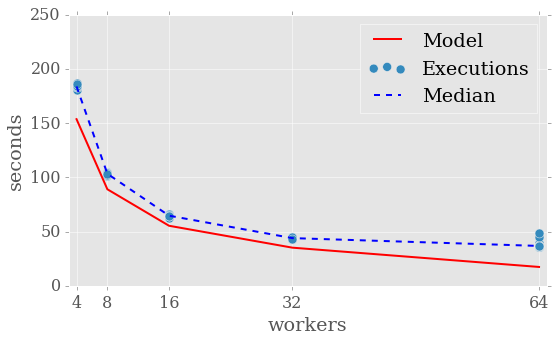

In [19]:
prof = dfs['wikipedia']['profiling']['features']
trgt = dfs['wikipedia']['target']['features']
model.fit(prof)
plotter = Plotter(xlim=(3, 65))
plotter.plot_model(model, trgt)

Prediction of the Wikipedia application target execution duration.

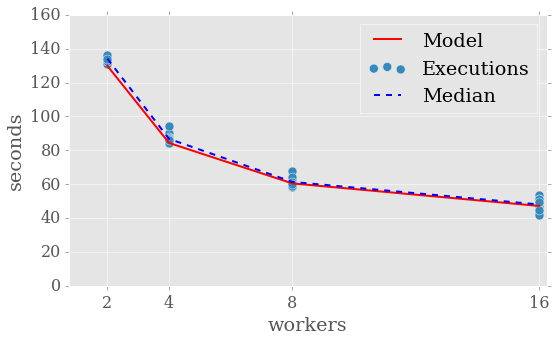

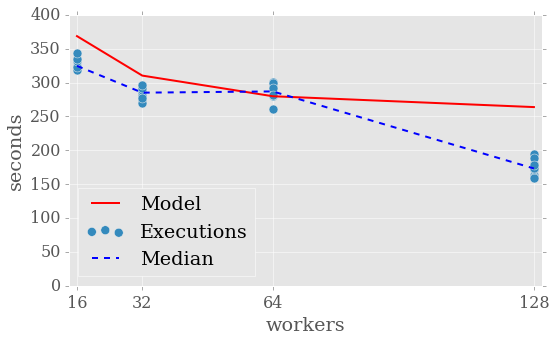

In [20]:
prof = dfs['hbsort']['profiling']['features']
trgt = dfs['hbsort']['target']['features']
model.fit(prof)
plotter = Plotter(xlim=(0.75, 16.25))
plotter.plot_model(model, trgt[trgt.input < 15 * 1024**3])
plotter = Plotter(xlim=(14, 130))
plotter.plot_model(model, trgt[trgt.input > 15 * 1024**3])

The top figure is the result of the HiBench Sort application with 3-GB input. The second figure uses 31-GB of data.

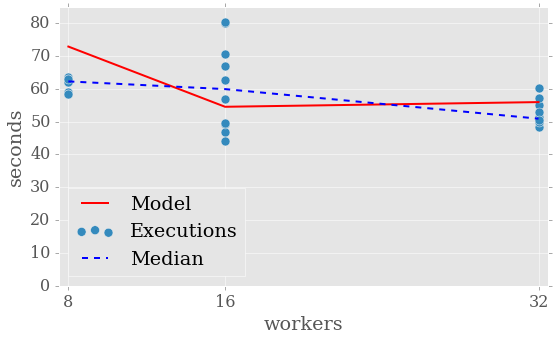

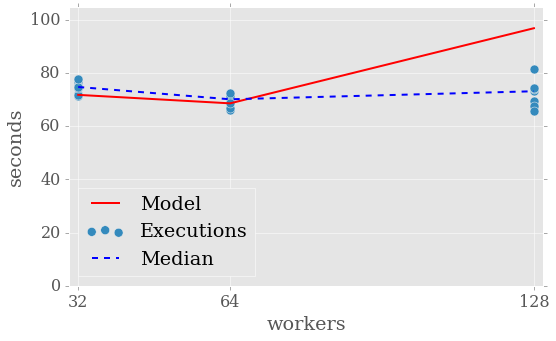

In [22]:
prof = dfs['hbkmeans']['profiling']['features']
trgt = dfs['hbkmeans']['target']['features']
model.fit(prof)
plotter = Plotter(xlim=(7.5, 32.5))
plotter.plot_model(model, trgt[trgt.input == 16384000])
plotter = Plotter(xlim=(30, 130))
plotter.plot_model(model, trgt[trgt.input == 65536000])

# Conclusion
There are two major findings in this work. One is that the best model to predict the profiling set performs poorly in the target prediction. The other is that, despite of being two different applications, we were able to find one model that has good results for all target number of workers of the Wikipedia application and also for the HiBench Sort benchmark, from 2 to 64 workers using 3 and 31 GB of input data.